Impact cost:

* [Impact Cost calculation](https://economictimes.indiatimes.com/definition/impact-cost#:~:text=Definition%3A%20Impact%20cost%20is%20the,liquidity%20condition%20on%20the%20counter.&text=This%20is%20a%20cost%20that,to%20lack%20of%20market%20liquidity).
* [Limit Order Books](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/cfm-imperial-institute-of-quantitative-finance/events/imperial-eth-2016/Julius-Bonart.pdf)

In [1]:
import pandas as pd
import numpy as np
import etl
import config as cfg
import feature_engineering as fe
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from ngboost import NGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
import shap
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import ml_modelling as ml
import visualization as viz
import shap
shap.initjs()

scaler = MinMaxScaler((-100,100))
asks_merged_df, bids_merged_df = fe.get_data(sin_cos_transform=True)
for df in [asks_merged_df, bids_merged_df]:
    df[cfg.Y_COL] = scaler.fit_transform(df[cfg.Y_COL])

In [2]:
asks_merged_df.shape

(1014, 23)

# Train best CV model for 30-min intervals 
1. Draw PDP plots using sci-kit learn model
1. Draw SHAP models

In [15]:
short_time_models = {
    "NGBRegressor":{
        "model":NGBRegressor(verbose=False),
        "mse":None,
    },
    "ExtraTreesRegressor":{
        "model":ExtraTreesRegressor(max_depth=3, n_estimators=16),
        "mse":None,
    }
}

def get_3d_pdp_plot(merged_df, models_dict, save_path):
    """
    """  
    X, y = merged_df[cfg.X_COLS], merged_df[cfg.Y_COL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=cfg.RANDOM_STATE)

    models_dict = viz.train_models(models_dict, X_train, y_train, X_test, y_test)

    ax, plot = viz.get_partial_dependence_plots(
        model = models_dict["ExtraTreesRegressor"]["model"],
        X_input = X_test,
        save_path= save_path,
    )
    return models_dict

def get_save_3d_pdps(asks_merged_df, bids_merged_df, freq):
    assert freq in ["30min", "daily"], "Frequency must be `30min` or `daily"
    if freq == "30min":
        asks_path = f"{viz.STRING_IMAGE}_30_mins_asks.png"
        bids_path = f"{viz.STRING_IMAGE}_30_mins_bids.png"
    else:
        asks_path = f"{viz.STRING_IMAGE}_daily_asks.png"
        bids_path = f"{viz.STRING_IMAGE}_daily_bids.png"
    asks_models_dict = get_3d_pdp_plot(asks_merged_df, short_time_models, cfg.FOLDER_PATHS_DICTS["FIGURES"] / asks_path)
    bids_models_dict = get_3d_pdp_plot(bids_merged_df, short_time_models, cfg.FOLDER_PATHS_DICTS["FIGURES"] / bids_path)
    
    models_dict = {
        "asks":asks_models_dict,
        "bids":bids_models_dict
    }
    return models_dict

Fitting model: NGBRegressor
MSE for NGBRegressor: 41.34
Fitting model: ExtraTreesRegressor
MSE for ExtraTreesRegressor: 403.34
Generating plots
Sucessfully saved image to: /home/philip/PhilipMLGithub/GAM_TEST/gam_test/reports/figures/best_ml_model_interval__30_mins_asks.png
Fitting model: NGBRegressor
MSE for NGBRegressor: 31.17
Fitting model: ExtraTreesRegressor
MSE for ExtraTreesRegressor: 456.54
Generating plots
Sucessfully saved image to: /home/philip/PhilipMLGithub/GAM_TEST/gam_test/reports/figures/best_ml_model_interval__30_mins_bids.png


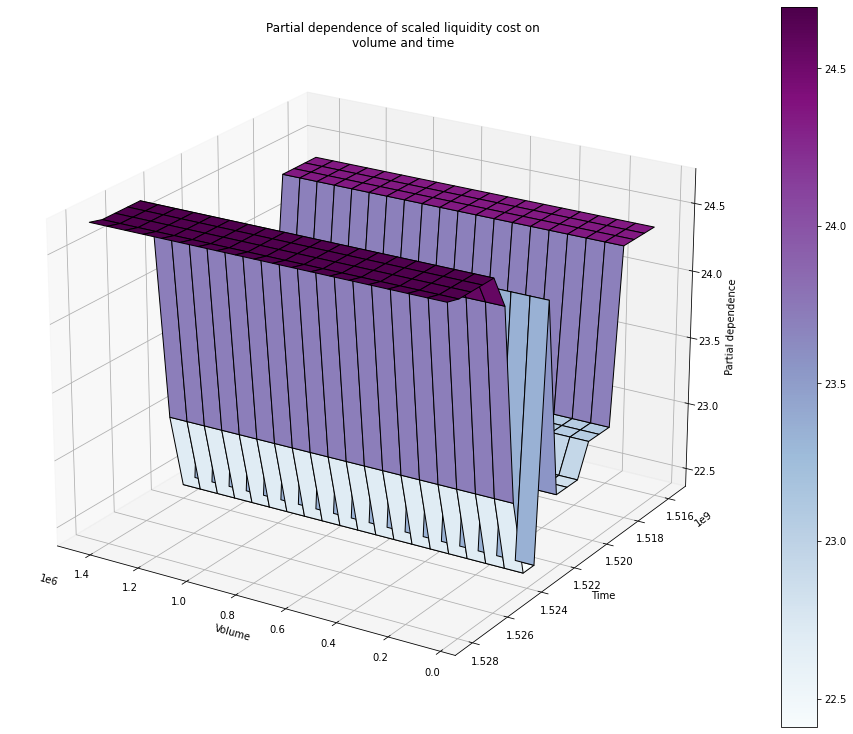

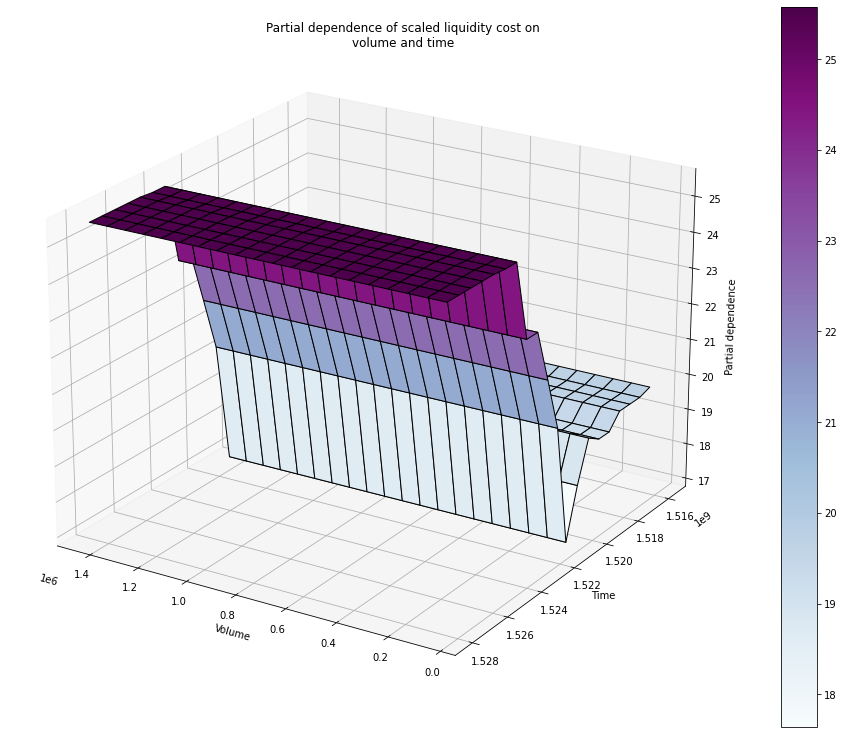

In [16]:
short_models_dict = get_save_3d_pdps(asks_merged_df, bids_merged_df, freq="30min")

### SHAP models

In [17]:
short_models_dict

{'asks': {'NGBRegressor': {'model': NGBRegressor(random_state=RandomState(MT19937) at 0x7F579005F140, verbose=False),
   'mse': 31.17},
  'ExtraTreesRegressor': {'model': ExtraTreesRegressor(max_depth=3, n_estimators=16),
   'mse': 456.54}},
 'bids': {'NGBRegressor': {'model': NGBRegressor(random_state=RandomState(MT19937) at 0x7F579005F140, verbose=False),
   'mse': 31.17},
  'ExtraTreesRegressor': {'model': ExtraTreesRegressor(max_depth=3, n_estimators=16),
   'mse': 456.54}}}

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Translating model_ouput="raw" to model_output=0 for the 0-th parameter in the distribution. Use model_output=0 directly to avoid this warning.


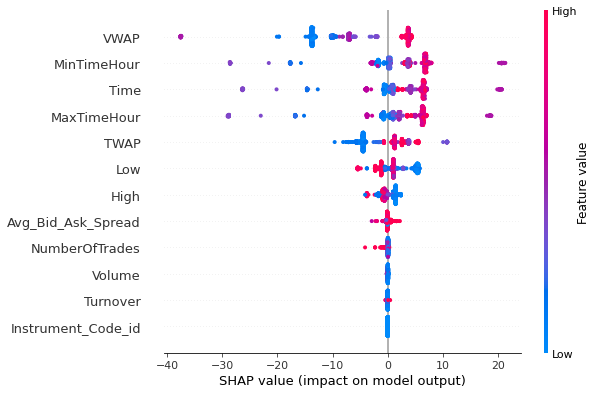

In [18]:
curr_model = short_models_dict["bids"]["NGBRegressor"]["model"]
X, y = bids_merged_df[cfg.X_COLS], bids_merged_df[cfg.Y_COL]
viz.shap_summary_plots(curr_model, X)

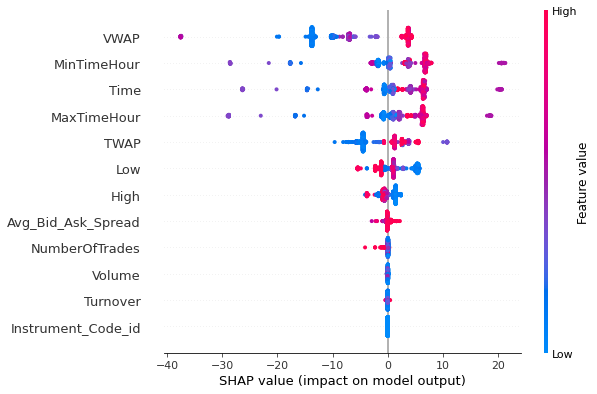

In [19]:
curr_model = short_models_dict["asks"]["NGBRegressor"]["model"]
X, y = asks_merged_df[cfg.X_COLS], asks_merged_df[cfg.Y_COL]
viz.shap_summary_plots(curr_model, X)

In [20]:
explainer = shap.TreeExplainer(curr_model)
shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

# Train best CV model for daily intervals 
1. Draw PDP plots using sci-kit learn model
1. Draw SHAP models

In [21]:
X_asks_long = fe.split_by_window_size(asks_merged_df[cfg.X_COLS], window_size=cfg.WINDOW_SIZE)
y_asks_long = fe.split_by_window_size(bids_merged_df[cfg.Y_COL], window_size=cfg.WINDOW_SIZE)
asks_merged_df_long = pd.concat([X_asks_long,y_asks_long],axis=1)


X_bids_long = fe.split_by_window_size(asks_merged_df[cfg.X_COLS], window_size=cfg.WINDOW_SIZE)
y_bids_long = fe.split_by_window_size(bids_merged_df[cfg.Y_COL], window_size=cfg.WINDOW_SIZE)
bids_merged_df_long = pd.concat([X_bids_long,y_bids_long],axis=1)

Fitting model: NGBRegressor


overflow encountered in square


MSE for NGBRegressor: 4.39
Fitting model: ExtraTreesRegressor
MSE for ExtraTreesRegressor: 450.99
Generating plots
Sucessfully saved image to: /home/philip/PhilipMLGithub/GAM_TEST/gam_test/reports/figures/best_ml_model_interval__daily_asks.png
Fitting model: NGBRegressor
MSE for NGBRegressor: 4.39
Fitting model: ExtraTreesRegressor
MSE for ExtraTreesRegressor: 510.17
Generating plots
Sucessfully saved image to: /home/philip/PhilipMLGithub/GAM_TEST/gam_test/reports/figures/best_ml_model_interval__daily_bids.png


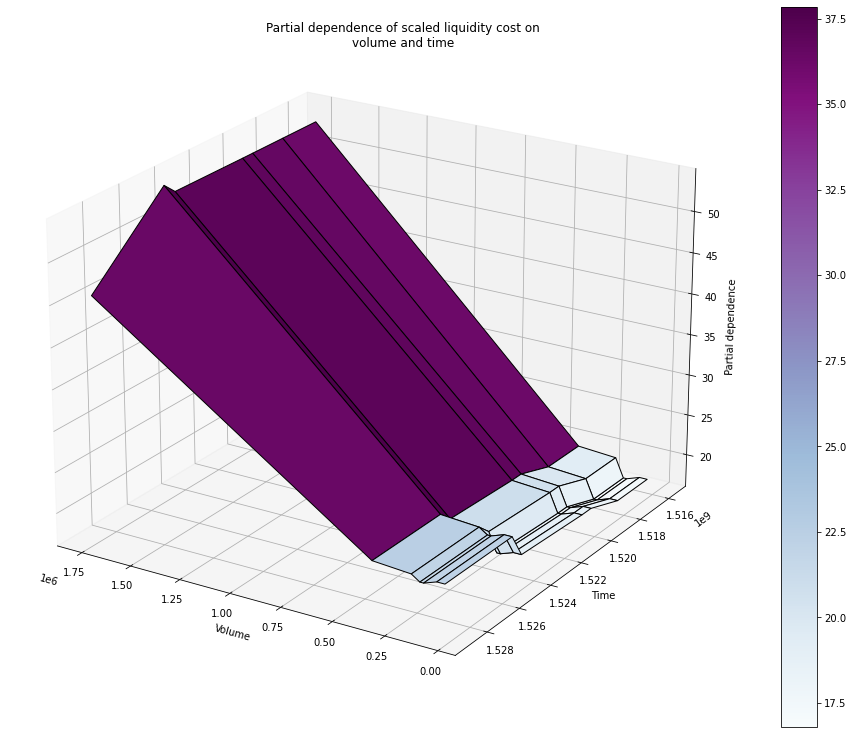

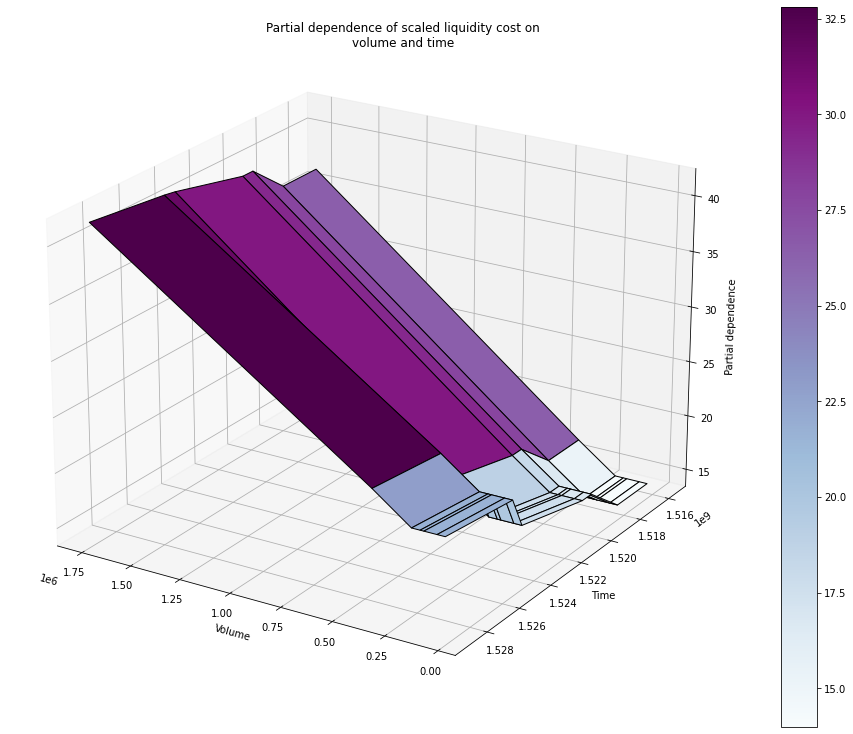

In [22]:
long_models_dict = get_save_3d_pdps(asks_merged_df_long, bids_merged_df_long, freq="daily")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Translating model_ouput="raw" to model_output=0 for the 0-th parameter in the distribution. Use model_output=0 directly to avoid this warning.


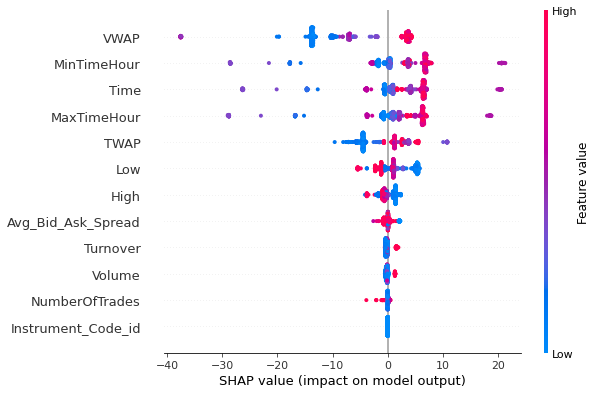

In [23]:
curr_model = long_models_dict["bids"]["NGBRegressor"]["model"]
X, y = asks_merged_df[cfg.X_COLS], asks_merged_df[cfg.Y_COL]
viz.shap_summary_plots(curr_model, X)